# Data Preprocessing for Reddit Autos Selfposts<div class="tocSkip">
    
&copy; Jens Albrecht, 2023
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

See also: 

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)  
Chapter 4: [Preparing Data for Statistics and Machine Learning](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html#ch-preparation) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2023-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

# Loading the Data Set

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".", parse_dates=['created'])

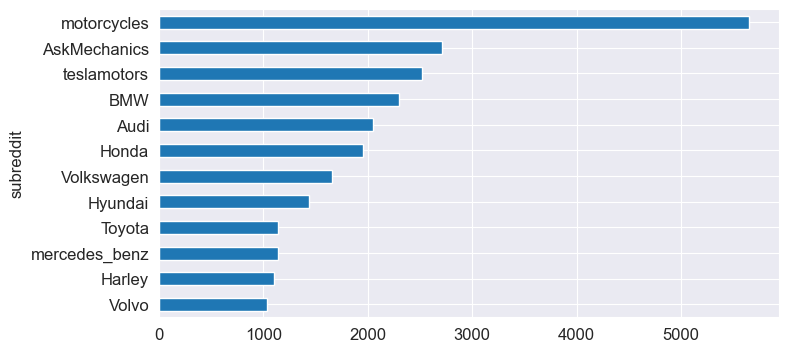

In [4]:
df['subreddit'].value_counts().head(20).plot(kind='barh').invert_yaxis()

In [5]:
df.dtypes

subreddit               object
id                      object
created         datetime64[ns]
title                   object
text                    object
num_comments             int64
url                     object
dtype: object

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
created,24712,2021-03-24 13:31:37.907818240,2021-01-01 00:05:03,2021-02-12 00:32:40,2021-04-02 14:09:49.500000,2021-05-04 03:14:40.750000128,2021-05-31 23:51:36,NaN
num_comments,24712.00,11.61,0.00,2.00,5.00,11.00,1320.00,33.58


In [7]:
df.describe(include='O').T

,count,unique,top,freq
subreddit,24712,12,motorcycles,5654
id,24712,24712,ko049k,1
title,24712,24259,"Daily Discussion, Question and Answer, Experiences, and Support Thread",90
text,24712,24483,"Daily Q&amp;A, Discussion, Owner Experience, and Support Thread: If you are new here (or even if you're not), please skim through our Rules to get more familiarity on potential updates or changes ...",34
url,24712,24712,https://www.reddit.com/r/motorcycles/comments/ko049k/help_plastic_melted_to_exhaust/,1


# Linguistic Processing with spaCy


## Instantiating a Pipeline


In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x14cb2c42140>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x14cb2c41ba0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x14cb2c502e0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x14cb2106540>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x14cb2479000>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x14cb72b1cb0>)]

## Processing Text


In [10]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

In [11]:
doc = nlp(text)

In [12]:
for token in doc:
    print(token, end="|")

The|BMW|X5|and|the|Mercedes|GLK|are|interesting|cars|.|Does|VW|have|models|like|these|?|

In [13]:
from blueprints.preparation import display_nlp

display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,The,the,True,True,DET,det,,O
1,BMW,BMW,False,True,PROPN,compound,ORG,B
2,X5,x5,False,False,NOUN,nsubj,PRODUCT,B
3,and,and,True,True,CCONJ,cc,,O
4,the,the,True,True,DET,det,,O
5,Mercedes,Mercedes,False,True,PROPN,compound,,O
6,GLK,GLK,False,True,PROPN,conj,,O
7,are,be,True,True,AUX,ROOT,,O
8,interesting,interesting,False,True,ADJ,amod,,O
9,cars,car,False,True,NOUN,attr,,O


## Extracting Lemmas based on Part-of-Speech


In [14]:
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[BMW, X5, Mercedes, GLK, cars, VW, models]


In [15]:
def extract_lemmas(doc, include_pos=None, exclude_pos=[]):
    return [t.lemma_ 
            for t in doc 
            if (include_pos==None or t.pos_ in include_pos) and t.pos_ not in exclude_pos]

lemmas = extract_lemmas(doc, include_pos=['NOUN', 'PROPN'])
print(lemmas)

['BMW', 'x5', 'Mercedes', 'GLK', 'car', 'VW', 'model']


## Extracting Named Entities

### Model-based Named Entity Recognition (NER)


In [16]:
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(BMW, ORG) (X5, PRODUCT) (VW, ORG) 

In [17]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [18]:
def extract_entities(doc, include_types=None):

    return [t.text for t in doc if t.ent_type_ in include_types]

print(extract_entities(doc, ['ORG', 'PERSON']))

['BMW', 'VW']


### Rule-based NER

In [19]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities")

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [20]:
import cars

cars.brands[:5]
cars.models[:5]

['alfa romeo', 'audi', 'bmw', 'chevrolet', 'chrysler']

['100', '100 avant', '100 d', '100 d', '100 nx']

Choose a relaxed pattern - favors high recall but will result in false positives

In [21]:
patterns = [{"label": "BRAND", 
             "pattern": [{"LOWER": {"IN": cars.brands}, 
                          "POS": {"IN": ["PROPN", "NOUN", "ADJ"] }
                         }]},
            {"label": "MODEL", 
             "pattern": [{"LOWER": {"IN": cars.models}, 
                          "POS": {"IN": ["PROPN", "NOUN", "ADJ"] }
                         }]}]

In [22]:
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

In [23]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [24]:
'spark' in cars.models

True

In [25]:
text = "The spark plugs in my Z4 are making trouble."

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [26]:
text = "I currently have a 2018 honda civic that I'd be getting rid of"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [27]:
text = "I hate Mercedes A-Class"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [28]:
text = "I hate A Mercedes"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,I,I,True,True,PRON,nsubj,,O
1,hate,hate,False,True,VERB,ROOT,,O
2,A,a,True,True,DET,det,,O
3,Mercedes,mercede,False,True,NOUN,dobj,BRAND,B


In [29]:
text = "Is a 2017 Tesla Model S worth it in 2023?"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,Is,be,True,True,AUX,ROOT,,O
1,a,a,True,True,DET,det,,O
2,2017,2017,False,False,NUM,nummod,DATE,B
3,Tesla,Tesla,False,True,PROPN,compound,BRAND,B
4,Model,Model,False,True,PROPN,compound,,O
5,S,S,False,True,PROPN,nsubj,MODEL,B
6,worth,worth,False,True,ADJ,acomp,,O
7,it,it,True,True,PRON,npadvmod,,O
8,in,in,True,True,ADP,prep,,O
9,2023,2023,False,False,NUM,pobj,DATE,B


## Blueprint: One Function to Get It All


In [30]:
def extract_nlp(doc):
    return {
    'lemmas' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'NUM']),
    'nouns'  : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'brands' : extract_entities(doc, ['BRAND']),
    'models' : extract_entities(doc, ['MODEL'])
    }

In [31]:
nlp = spacy.load('en_core_web_sm', disable=[])

_ = nlp.add_pipe("merge_entities")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

[pipe[0] for pipe in nlp.pipeline]

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'merge_entities',
 'entity_ruler']

In [32]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['BMW', 'x5', 'Mercedes', 'GLK', 'interesting', 'car', 'VW', 'have', 'model']
nouns: ['BMW', 'x5', 'Mercedes', 'GLK', 'car', 'VW', 'model']
brands: ['BMW', 'Mercedes', 'VW']
models: ['X5', 'GLK']


In [33]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'nouns', 'brands', 'models']


## Blueprint: Using spaCy on a Large Data Set


In [34]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".")

In [35]:
pd.options.display.max_colwidth = 1000
df[['subreddit', 'text']].sample(3)

,subreddit,text
860,Harley,Best Harley for learning how to work on bikes?: I currently have a 2020 FXBB that I love. I have done some upgrades but nothing major. I'm looking to buy a project bike. What is a good harley to learn how to wrench on for the first time?
7049,Volkswagen,"Replace clutch lines 08 Golf Mk5 R32: Hey All, Vehicle is a 2008 Golf Mk5 R32 190 000km based in Australia. In the past 12 months the following items have been replaced relating to the clutch system: Clutch Plate Dual mass flywheel Slave Cylinder Master Cylinder Air is very slowly entering the hydraulic system from somewhere and I would like to replace the lines as besides the reservoir this is the only item that isn't new. I'm assuming at almost 190 000km it is a reasonable idea to replace it. After a lot of searching I cannot find anywhere to buy a replacement clutch line. Is it worth replacing it with a stainless steel flexible clutch line resulting in the swirl valve being removed? I also can't even find one to fit a Mk5 R32. Seems parts relating to the clutch hydraulics are easy enough to find for Mk4 R32, and all Rs just not the Mk5. If anyone can point me in the right direction as well as any advice relating to the clutch hydraulics that would be greatly appreciated."
2538,Harley,"Newbie Downshifting Question: Hey y'all, newbie question. Been riding 3>2>1 while slowing down to a stop (all while holding the clutch in). Just to note, I wasn't doing a quick successive drop it was more of a slow drop in gears matching my speed to the gear I would've been in. I recently upgraded my bike (20 HD low rider s) and won't let let me do 4>3>2>1 while holding the clutch in. I have to release the clutch every time and then reengage for every gear going down. If I don't the gear lever gets 'floppy' or 'dead' and does not shift down. I don't get the positive 'click' when going down. I'll end up stuck at a red light in 3rd. In the end it's clutch in, 4th, clutch out, clutch in, 3rd, clutch out, clutch in 2nd...etc. Is this rider error? Was I doing it incorrectly on my 883? Really appreciate the insight/advice."


In [36]:
for col in nlp_columns:
    df[col] = None

In [37]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [38]:
nlp = spacy.load('en_core_web_sm', disable=[])

_ = nlp.add_pipe("merge_entities")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

In [39]:
# full data set takes about 5 minutes
# for faster processing use a sample like this
df = df.sample(500)

In [40]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
df[['text', 'lemmas', 'brands', 'models']].sample(10)

,text,lemmas,brands,models
11607,"i changed the transmission oil in my CR125 2002 with 0W-40 oil, and the manual says it recommends 10W-40 (could not find a jaso rating): i changed the transmission oil in my CR125 2002 with 0W-40 oil, and the manual says it recommends 10W-40 (could not find a jaso rating) i'll change it in the future, but would it ruin the bike if i had it out for one ride with this oil? say a 3 or more hour ride?","[change, transmission, oil, CR125, 2002, oil, manual, say, recommend, 10w-40, find, jaso, rating, change, transmission, oil, CR125, 2002, oil, manual, say, recommend, 10w-40, find, jaso, rating, change, future, ruin, bike, have, one, ride, oil, say, 3 or more hour, ride]",[],[]
8202,"replacing a windshield with one from the salvage yard - what's your technique/routine?: replacing a windshield with one from the salvage yard what's your technique/routine? this is for a 2000 Camry I've watched the Youtube videos and it looks so easy, and they say it's easy but IDK. Have to watch it again. I tested my technique at the salvage yard on another car (not my target) that had an already cracked windshield for practice. I cracked it in another place. I don't know what's wrong with my technique I pushed the tool through the caulk and the minute I applied any force pulling on the wire, the glass cracked at the edge. Once it's out How do you guys get the windshield home in one piece? I thought about going to a windshield place and getting one of the 500 windshield crates they have behind the shop, and using that to bring the replacement home on the roof of my car or on a trailer. The Safelite (etc) guys have a van with lots of room; I have a Camry.","[replace, windshield, one, salvage, yard, technique, routine, replace, windshield, one, salvage, yard, technique, routine, 2000, Camry, watch, Youtube, video, look, easy, say, easy, IDK, have, watch, test, technique, salvage, yard, car, target, have, crack, windshield, practice, crack, place, know, wrong, technique, push, tool, caulk, minute, apply, force, pull, wire, glass, crack, edge, guy, get, windshield, one, piece, think, go, windshield, place, get, one, 500, windshield, crate, have, shop, use, bring, replacement, home, roof, car, trailer, Safelite, guy, have, van, lot, room, have, Camry]",[],"[Camry, edge, Camry]"
12914,"I passed!: I posted on here a while back about foolishly signing up for a one day intermediate course and not passing the skills test. I was pretty bummed at the time. Took the two day basic course this weekend and passed with flying colors. Now it's just a waiting game to get in to the DMV for my written knowledge test, then on to purchasing a bike. Thank you to the folks on here that posted at that time sharing their experiences and offering words of support. Hope to see you on the road soon!","[pass, post, while, sign, one, day, intermediate, course, pass, skill, test, bum, time, take, two day, basic, course, this weekend, pass, fly, color, wait, game, get, DMV, write, knowledge, test, purchase, bike, thank, folk, post, time, share, experience, offer, word, support, hope, see, road]",[],[]
14620,How bad is a DCT automatic on Hyundais?: I've never owned a vehicle with a DCT and have only driven traditional torque converter automatics. I was looking into getting a 2021 Kona but some of the reviewers kept complaining about how jerky or hesitant the transmission was. I just want to know how much a difference it can make to daily driving it and if it's something that can make such a significant difference that I should avoid it altogether. I know this is a Hyundai subreddit but I would really appreciate candid responses as opposed to biased ones. I currently own an Elantra and love the warranty on their cars.,"[bad, dct, automatic, Hyundais, own, vehicle, dct, drive, traditional, torque, converter, automatic, look, get, 2021, Kona, reviewer, keep, complain, jerky, hesitant, transmission, want, know, much, difference, make, daily, drive, make, s

# Finalizing and Saving the Result

## Some Quick Frequency Analyses

  0%|          | 0/500 [00:00<?, ?it/s]

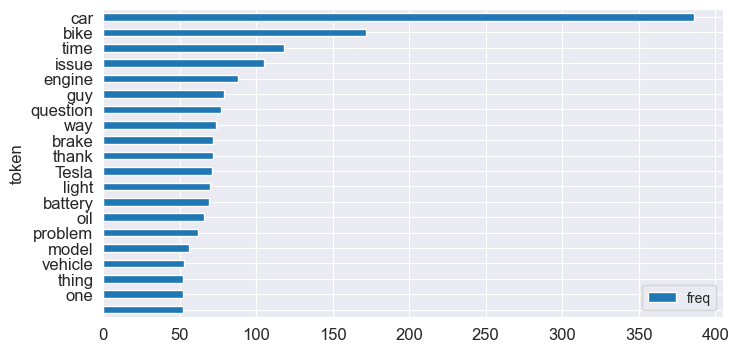

In [43]:
from blueprints.exploration import count_words

freq_df = count_words(df, 'nouns')

freq_df.head(20).plot(kind='barh').invert_yaxis()

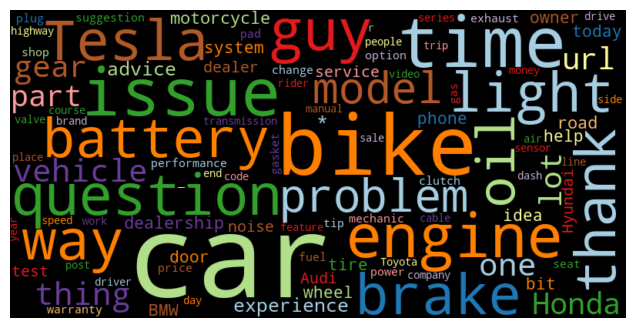

In [44]:
from blueprints.exploration import wordcloud

wordcloud(freq_df['freq'], max_words=100)

  0%|          | 0/500 [00:00<?, ?it/s]

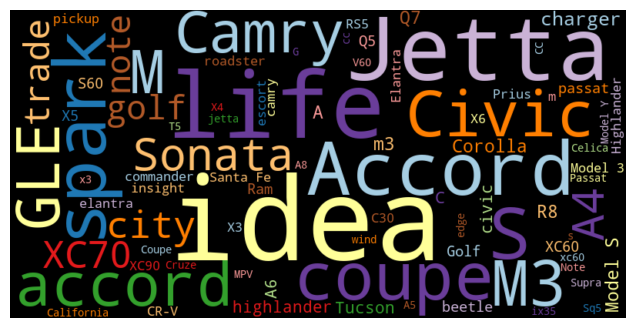

In [45]:
freq_df = count_words(df, 'models')
wordcloud(freq_df['freq'])

  0%|          | 0/500 [00:00<?, ?it/s]

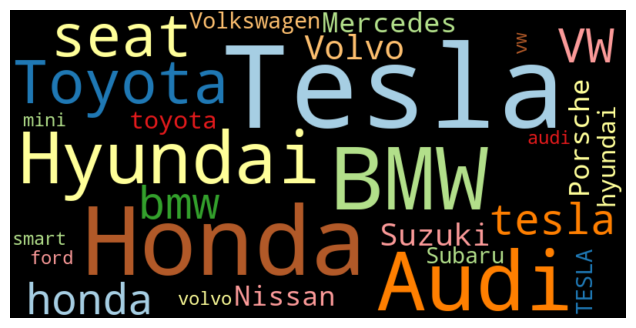

In [46]:
freq_df = count_words(df, 'brands')
wordcloud(freq_df['freq'])

## Synonym Resolution

In [47]:
synonyms = { brand: brand for brand in cars.brands }
synonyms['mercedes-menz'] = 'mercedes'
synonyms['volkswagen'] = 'vw'

df['brands'] = df['brands'].progress_map(lambda brands: [synonyms[b.lower()] for b in brands])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

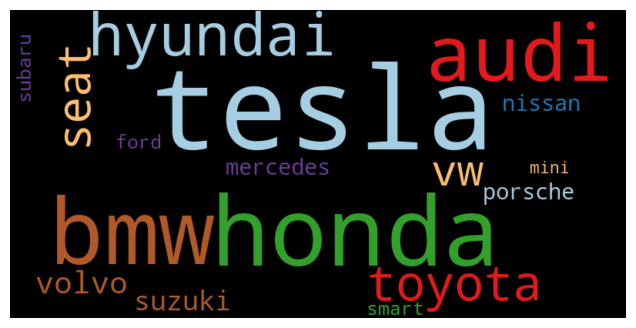

In [48]:
freq_df = count_words(df, 'brands')
wordcloud(freq_df['freq'])

## Saving the Prepared Data

Alternatively into a SQL database or JSON file.

In [49]:
# convert lists of tokens into space-separated strings for csv-saving
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items).lower())

# df.to_csv(f"reddit-autos-selfposts-prepared.csv", sep=";", decimal=".", index=False)

In [50]:
# restore lists
# df[nlp_columns] = df[nlp_columns].applymap(lambda items: items.split())